# M2 SIA
- **<span style="color:red;">DUCROCQ</span> Romain**
- **<span style="color:red;">GRUMBACH</span> Natacha**  
- **<span style="color:red;">JABER</span> Sara**  
- **<span style="color:red;">THEROND</span> Alexandre**  

# Deezer playlist dataset and song recommendation with word2vec

In this mini project we will develop a word2vec network and use it to build a playlist completion tool (song suggestion). The data is hosted on the following repository: http://github.com/comeetie/deezerplay.git. To know more about word2vec and these data you can read the two following references:

- Efficient estimation of word representations in vector space, Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. (https://arxiv.org/abs/1301.3781)
- Word2with applied to Recommendation: Hyperparameters Matter, H. Caselles-Dupré, F. Lesaint and J. Royo-Letelier. (https://arxiv.org/pdf/1804.04212.pdf)

The elements you have to do are highlighted in red.

## Preparation of data

The data is in the form of a playlist list. Each playlist is a list with the deezer ID of the psong followed by the artist ID.

In [1]:
import numpy as np
data = np.load("./music_2.npy",allow_pickle=True)
[len(data), np.mean([len(p) for p in data])]

[100000, 24.21338]

The dataset we are going to work on contains 100000 playlists which are composed of an average of 24.1 songs. We will start by keeping only the song identifiers. 

In [2]:
playlist_track = [list(filter(lambda w: w.split("_")[0]==u"track",playlist)) for playlist in data]
playlist_artist = [list(filter(lambda w: w.split("_")[0]==u"artist",playlist)) for playlist in data]

In [3]:
# songs != ?
tracks = np.unique(np.concatenate(playlist_track))
Vt = len(tracks)
Vt

338509

The number of different songs in this data-set is quite high with more than 300,000 songs.

## Creating a song dictionary
We will assign to each song an integer that will serve as a unique identifier and input for our network. In order to save a little bit of resources we will only work in this project on songs that appear in at least two playlists.

In [4]:
# how many occurence for each track ?
track_counts = dict((tracks[i],0) for i in range(0, Vt))
for p in playlist_track:
    for a in p:
        track_counts[a]=track_counts[a]+1;

In [5]:
# Filter very rare songs to save ressources
playlist_track_filter = [list(filter(lambda a : track_counts[a]> 1, playlist)) for playlist in playlist_track]
# get the counts
counts  =  np.array(list(track_counts.values()))
# sort
order = np.argsort(-counts)
# deezed_id array
tracks_list_ordered = np.array(list(track_counts.keys()))[order]
# Vocabulary size = number of kept songs
Vt=np.where(counts[order]==1)[0][0]
# dict construction id_morceaux num_id [0,Vt]
track_dict = dict((tracks_list_ordered[i],i) for i in range(0, Vt))
# playlist conversion to list of integers
corpus_num_track = [[track_dict[track] for track in play ] for play in playlist_track_filter]

### Creation of test and validation learning sets

To learn the parameters of our method we will keep the first l-1 songs of each playlist (with l the length of the playlist) for learning. To evaluate the completion performance of our method we keep for each playlist the last two songs. The objective will be to find the last one from the next-to-last one. 



In [6]:

# playlist main part used for trainning
play_app  = [corpus_num_track[i][:(len(corpus_num_track[i])-1)] 
             for i in range(len(corpus_num_track)) if len(corpus_num_track[i])>1]
# the two last elements are used for validation and training
index_tst = np.random.choice(100000,20000)
index_val = np.setdiff1d(range(100000),index_tst)

play_tst  = np.array([corpus_num_track[i][(len(corpus_num_track[i])-2):len(corpus_num_track[i])] 
             for i in index_tst if len(corpus_num_track[i])>3])
play_val  = np.array([corpus_num_track[i][(len(corpus_num_track[i])-2):len(corpus_num_track[i])] 
             for i in index_val if len(corpus_num_track[i])>3])[:10000]


In [7]:
# import Keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,Flatten
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.preprocessing.sequence import skipgrams

### hyper-paramètres de word2vec :

La méthode word2vec fait intervennir un certains nombre d'hyper paramètres. Nous allons les définirs et leurs donner des première valeurs que nous affinerons par la suite:


In [8]:
# latent space dimension
vector_dim = 30
# window size
window_width = 3
# number of negative sample per positive sample
neg_sample = 5
# taille des mini-batch
min_batch_size = 50
# smoothing factor for the sampling table of negative pairs 
samp_coef = 0.5
# cparameter to sub-sample frequent song
sub_samp = 0.00001

### Creation of the draw probability tables (smoothed) and unsmoothed

To draw the negative examples we need the smoothed frequencies of each song in our dataset. Likewise to under-sample very frequent pieces we need the raw frequencies. We will calculate these two vectors.

In [9]:
# get the counts
counts = np.array(list(track_counts.values()),dtype='float')[order[:Vt]]
# normalization
st =  counts/np.sum(counts)
# smoothing
st_smooth = np.power(st,samp_coef)
st_smooth = st_smooth/np.sum(st_smooth)

### Building the word2 network with

A word2 network with takes in input two integers corresponding to two songs, these are embedded in a latent space of dimension (vector_dim) thanks to a layer of embedding type (you will have to use the same layer to project the two pieces). Once these two vectors have been extracted, the array must calculate their scalar product normalize appleler cosine distance : 

$$cos(\theta_{ij})=\frac{z_i.z_j}{||z_i||||z_j||}$$

To carry out this treatment you will use a "dot" layer for "dot product". The model then uses a sigmoid layer to produce the output. This output will be 0 when both songs are randomly drawn from the whole dataset and 1 when they were extracted from the same playslist. <span style="color:red">You have to create the keras Track2Vec model corresponding to this architecture.</span>


In [10]:
# inputs
input_target = Input((1,), dtype='int32')
input_context = Input((1,), dtype='int32')

embedding = Embedding(Vt, vector_dim, input_length=1, name='embedding')
target = embedding(input_target)
context = embedding(input_context)
dot_product = Dot(axes=2, normalize=True)([target, context])
dot_product = Flatten()(dot_product)

output = Dense(1, activation='sigmoid',name="classif")(dot_product)

Track2Vec = Model(inputs=[input_target, input_context], outputs=output)
Track2Vec.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])

In [11]:
Track2Vec.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        3697230     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1, 1)         0           embedding[0][0]              

### Creation of the data generator

To learn the projection layer at the heart of our model we will build a generator of positive and negative pair examples of close or random songs from our training data. The following function will allow us to generate such examples from a playlist (seq) provided as input. This function will first build all the pairs of songs that can be extracted from the playlist if they are within (windows) distance of each other. These pairs will constitute the positive pairs. The pairs concerning very frequent songs will be removed with a probability that depends on their frequencies. Finally a number of negative examples (corresponding to neg_samples * positive number of examples) will be randomly drawn using the neg_sampling_table.

In [12]:
# function to generate word2vec positive and begative pairs 
# from an array of int that represent a text ot here a playlist
# params 
# seq : input text or playlist (array of int)
# neg_samples : number of negative sample to generate per positive ones
# neg_sampling_table : sampling table for negative samples
# sub sampling_table : sampling table for sub sampling common words songs
# sub_t : sub sampling parameter
def word2vecSampling(seq,window,neg_samples,neg_sampling_table,sub_sampling_table,sub_t):
    # vocab size
    V = len(neg_sampling_table)
    # extract positive pairs 
    positives = skipgrams(sequence=seq, vocabulary_size=V, window_size=window,negative_samples=0)
    ppairs    = np.array(positives[0])
    # sub sampling
    if (ppairs.shape[0]>0):
        f = sub_sampling_table[ppairs[:,0]]
        subprob = ((f-sub_t)/f)-np.sqrt(sub_t/f)
        tokeep = (subprob<np.random.uniform(size=subprob.shape[0])) | (subprob<0)
        ppairs = ppairs[tokeep,:]
    nbneg     = ppairs.shape[0]*neg_samples
    # sample negative pairs
    if (nbneg > 0):
        negex     = np.random.choice(V, nbneg, p=neg_sampling_table)
        negexcontext = np.repeat(ppairs[:,0],neg_samples)
        npairs    = np.transpose(np.stack([negexcontext,negex]))
        pairs     = np.concatenate([ppairs,npairs],axis=0)
        labels    = np.concatenate([np.repeat(1,ppairs.shape[0]),np.repeat(0,nbneg)])
        perm      = np.random.permutation(len(labels))
        res = [pairs[perm,:],labels[perm]]
    else:
        res=[[],[]]
    return res

In [13]:
import random

def track_ns_generator(corpus_num, nbm):

    while True:
        res = [word2vecSampling(batch, window_width, neg_sample, st_smooth, st, sub_samp) for batch in random.sample(corpus_num, nbm)]
        xT = np.array([xi for xres in [r[0] for r in res if len(r[0]) > 0] for xi in xres], dtype=np.int32)
        y = np.array([yi for yres in [r[1] for r in res if len(r[1]) > 0] for yi in yres], dtype=np.int32)
        x = [xT[:,0], xT[:,1]]

        yield (x, y)


<span style="color:red">Use this function to build a "track_ns_generator" of data which will generate positive and negative examples from "nbm" playlists randomly drawn from the "corpus_num" dataset provided as input. </span>

## Learning 
You should now be able to learn your first model with the following code. This should take between 15 and 30 min.

In [14]:
# %%script false --no-raise-error
hist=Track2Vec.fit(x=track_ns_generator(play_app,min_batch_size),steps_per_epoch = 200,epochs=60)

Epoch 1/60
200/200 [==============================] - 16s 78ms/step - loss: 0.6616 - accuracy: 0.7945
Epoch 2/60
200/200 [==============================] - 16s 78ms/step - loss: 0.6070 - accuracy: 0.8396
Epoch 3/60
200/200 [==============================] - 16s 78ms/step - loss: 0.5621 - accuracy: 0.8402
Epoch 4/60
200/200 [==============================] - 16s 80ms/step - loss: 0.5243 - accuracy: 0.8436
Epoch 5/60
200/200 [==============================] - 16s 82ms/step - loss: 0.4920 - accuracy: 0.8481
Epoch 6/60
200/200 [==============================] - 16s 82ms/step - loss: 0.4634 - accuracy: 0.8542
Epoch 7/60
200/200 [==============================] - 17s 83ms/step - loss: 0.4382 - accuracy: 0.8614
Epoch 8/60
200/200 [==============================] - 17s 83ms/step - loss: 0.4172 - accuracy: 0.8663
Epoch 9/60
200/200 [==============================] - 17s 83ms/step - loss: 0.3971 - accuracy: 0.8725
Epoch 10/60
200/200 [==============================] - 17s 84ms/step - loss: 0.378

## Save latent space
Once the learning is done, we can save the position of the songs in the latent space with the following code:

In [15]:
# %%script false --no-raise-error
# récupérations des positions des morceaux dans l'espace de projection
vectors_tracks = Track2Vec.get_weights()[0]
with open('latent_positions.npy', 'wb') as f:
    np.save(f, vectors_tracks)

And latter load it with :

In [16]:
vectors_tracks=np.load("latent_positions.npy")

## Use in completion and evaluation
We can now use this space to make suggestions. <span style="color:red">Build a predict_batch function that takes as input a number vector of songs (seeds), (s) a number of suggestions to make per request, the vectors of the songs in the latent space X and a kd-tree to speed up the computation of closest neighbors. To make its propositions this function will return the indices of the s closest neighbors of each seed. </span> So that these predictions don't take too much time you will use a kd-tree (available in scikit learn) to speed up the search for nearest neighbors.

In [17]:
from sklearn.neighbors import KDTree
kdt = KDTree(vectors_tracks, leaf_size=10, metric='euclidean')

In [18]:
def predict_batch(seeds,k,X,kdt):
    return kdt.query(X[seeds,:], k=k+1, return_distance=False)[:,1:]

<span style="color:red">Use this function to propose songs to complete the playlist of the validation dataset (the seeds correspond to the first column of play_val).</span>

In [19]:
indexes = predict_batch(play_val[:,0],10,vectors_tracks,kdt)
indexes.shape

(10000, 10)

<span style="color:red">Compare these suggestions with the second column of play_val (the songs actually present). To do this you will calculate the hit@10 which is 1 if the song actually present in the playlist is one of the 10 suggestions (this score is averaged over the validation set) and the NDCG@10 (Normalized Discounted Cumulative Gain) which takes into account the order of the suggestions. This second score is worth $1/log2(k+1)$ if proposal k (k between 1 and 10) is the correct proposal and 0 if no proposal is correct. As before you will calculate the average score on the validation set. </span>


In [20]:
NDGCatK = sum([1/np.log2(k[0]+2) for k in 
               [np.where(indexes[i] == song)[0] for i, song in enumerate(play_val[:,1])] 
               if len(k) > 0]) / len(play_val[:,1])
NDGCatK

0.08050221924433909

In [21]:
HitatK = sum([song in indexes[i] for i, song in enumerate(play_val[:,1])]) / len(play_val[:,1])
HitatK

0.1407

## hyper parameters tunning

<span style="color:red">You can now try to vary the hyper parameters to improve your performance. Pay attention to the computing time : prepare a grid with about ten different configurations and evaluate each of them on your validation set.
Evaluate the final performance of the best configuration found on the test set. Don't forget to save your results.</span>



### <span style="color:green;">Introduction</span>

In this part, we aim at improving the performance by tuning the hyperparameters.

Thus, we want to find a configuration with better HitatK and NDGCatK values than in the initial setting, hence:
> - HitatK > 0.134 
> - NDGCatK > 0.075782

In order to do so, we will go through 3 progressive steps:
> 1. Replicate the configurations from the paper.
> 2. Tune the hyperparameters independently according to the ranges studied in the paper.
> 3. Combine the best values for the hyperparameters found at step 2 and tune the size of the mini batches.

For each of these, we will store the results of the configurations in pandas dataframes, and plot them with seaborn. Hereunder is our plotting function.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def disp_hp(df, hp, suptitle, y_lim_hitatk=(0.1, 0.16), y_lim_ndcgatk=(0.05, 0.1)):
    display(df)
    
    print(f"Max HitatK: {max(df['HitatK'])}, at {hp}: {df.loc[df['HitatK'] == max(df['HitatK']), hp].values[0]}")
    print(f"Max NDCGatK: {round(max(df['NDCGatK']), 6)}, at {hp}: {df.loc[df['NDCGatK'] == max(df['NDCGatK']), hp].values[0]}")

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    fig.suptitle(suptitle)
    axes[0].set_title("HitatK")
    axes[0].set_ylim(y_lim_hitatk[0], y_lim_hitatk[1])
    axes[1].set_title("NDCGatK")
    axes[1].set_ylim(y_lim_ndcgatk[0], y_lim_ndcgatk[1])

    sns.set_style("whitegrid", {'axes.grid' : True})
    sns.pointplot(ax=axes[0], x=hp, y='HitatK', data=df, kind='point')
    sns.pointplot(ax=axes[1], x=hp, y='NDCGatK', data=df, kind='point')
    None

### <span style="color:green;">Step 1: Configurations from the paper "Hyperparameters Matter"</span>

The paper presents 5 configurations for the "Deezer dataset" (Table 1), focusing on 4 hyperparameters:
> - window-size, number of epochs, sub-sampling parameter and negative sampling distribution parameter. 

In this part, we try all 5 configurations with our model.

The 5 configurations are:

> | config | window_width | epochs | sub_samp | samp_coef |
> | --- | --- | --- | --- | --- |
> | 1 | 5 | 5 | 0.001 | 0.75 |
> | 2 | 3 | 90 | 0.00001 | 0.75 |
> | 3 | 3 | 130 | 0.00001 | -0.5 |
> | 4 | 3 | 10 | 0.001 | 0.75 |
> | 5 | 3 | 150 | 0.0001 | -0.5 |

In [24]:
# Configurations from the paper
df_paper_config = pd.DataFrame({
    "config": [1, 2, 3, 4, 5],
    "HitatK": [0.0636, 0.12, 0.1146, 0.0981, 0.1073],
    "NDCGatK": [0.03481526476687495, 0.06977266919353489, 0.06517042551519638, 0.054810833369649696, 0.06032346801441803],
    "Loss": [0.4795, 0.1289, 0.0759, 0.3644, 0.0750],
    "Accuracy": [0.8636, 0.9521, 0.9733, 0.8853, 0.9729]
})

,config,HitatK,NDCGatK,Loss,Accuracy
0,1,0.0636,0.034815,0.4795,0.8636
1,2,0.1200,0.069773,0.1289,0.9521
2,3,0.1146,0.065170,0.0759,0.9733
3,4,0.0981,0.054811,0.3644,0.8853
4,5,0.1073,0.060323,0.0750,0.9729


Max HitatK: 0.12, at config: 2
Max NDCGatK: 0.069773, at config: 2


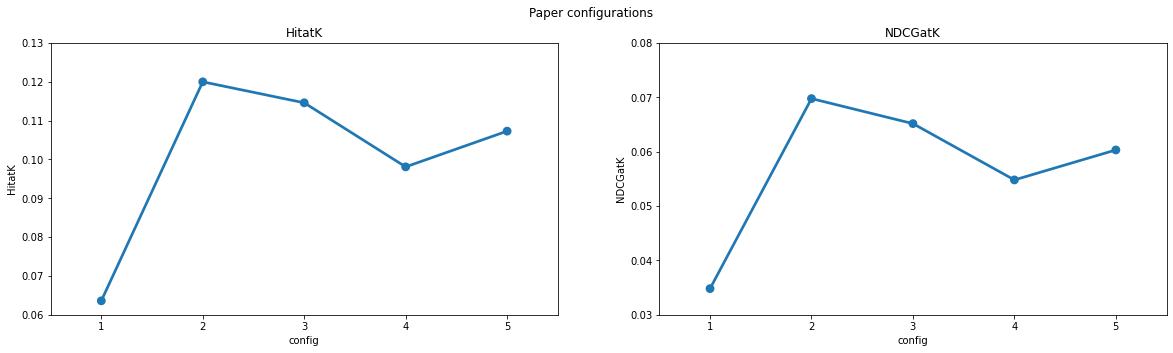

In [25]:
disp_hp(df_paper_config, "config", "Paper configurations", y_lim_hitatk=(0.06, 0.13), y_lim_ndcgatk=(0.03, 0.08))

> **Observation:** All configurations present different performances, as expected from the heterogeneity of the hyperparameters, with a max at config 2 (HitatK: 0.12, NDCGatK: 0.069773). None of them is better than our original settings, and we suppose the learning model from the paper to be build differently. Therefore, we must go with a different approach to find the optimal combination. 

### <span style="color:green;">Step 2: Tune one hyperparameter at a time</span>

In this second part, we want to determine the effect of each hyperparameter on the performance. In order to do so, we take our initial configuration and vary the hyperparameters one by one. We focus on the 6 hyperparameters studied in the paper:
> - window size, negative sample, sub-sample, sample coefficient, epochs and latent space dimension.

For each of these hyperparameters, we vary the value of the one to be observed within the range given by the paper, while leaving the 5 others as in the initial settings. We thus determine what is the optimal value for each parameter.

The default values are given by the initial configuration, such that:
> - window_width = 3, neg_sample = 5, sub_samp = 0.00001, samp_coef = 0.5, epochs = 60, vector_dim = 30.

The ranges used to vary the hyperparameters are as follow:
> - window_width = {3, 5, 7, 12}.
> - neg_sample = {5, 10, 15, 20}.
> - sub_samp = {0.00001, 0.0001, 0.001, 0.01, 0.1}
> - samp_coef = {-1.4, -1.2, -1, -0.6, -0.2, 0, 0.2, 0.5, 0.7, 1, 1.4}.
> - epochs = {10, 50, 60, 90, 110, 150, 200}.
> - vector_dim = {30, 50, 100, 150, 200}.

In [26]:
# Window size
df_window_size = pd.DataFrame({
    "window_width": [3, 5, 7, 12],
    "HitatK": [0.136, 0.1324, 0.1279, 0.1281],
    "NDCGatK": [0.0781639990893966, 0.0729412041239134, 0.069621848982446, 0.06842284402101971],
    "Loss": [0.1363, 0.1440, 0.1600, 0.1597],
    "Accuracy": [0.9519, 0.9481, 0.9415, 0.9411]
})

# Negative sample
df_neg_sample = pd.DataFrame({
    "neg_sample": [5, 10, 15, 20],
    "HitatK": [0.1321, 0.1469, 0.1502, 0.1545],
    "NDCGatK": [0.07529, 0.08354696808513656, 0.0843, 0.08757],
    "Loss": [0.1376, 0.0989, 0.0789, 0.0701],
    "Accuracy": [0.9508, 0.9670, 0.9749, 0.9783]
})

# Sub-sample
df_sub_samp = pd.DataFrame({
    "sub_samp": [0.00001, 0.0001, 0.001, 0.01, 0.1],
    "HitatK": [0.134, 0.1348, 0.1419, 0.1346, 0.1408],
    "NDCGatK": [0.0757820569218288, 0.0760823769731717, 0.08079103643076838, 0.07660699849204425, 0.0793149272484648],
    "Loss": [0.1367, 0.1508, 0.1551, 0.1484, 0.1503],
    "Accuracy": [0.9508, 0.9440, 0.9422, 0.9449, 0.9442]
})

# Sample coefficient
df_samp_coef = pd.DataFrame({
    "samp_coef": [-1.4, -1.2, -1, -0.6, -0.2, 0, 0.2, 0.5, 0.7, 1, 1.4],
    "HitatK": [0.1167, 0.1223, 0.1207, 0.1275, 0.1301, 0.1354, 0.1359, 0.1393, 0.1287, 0.126, 0.0056],
    "NDCGatK": [0.0673763718, 0.0707799892, 0.0682275416, 0.0736438937, 0.0737298494, 0.0771398816, 0.0767850767, 0.0794541365, 0.0744859737, 0.0751430851, 0.0029024131
],
    "Loss": [0.1026, 0.114, 0.1098, 0.1212, 0.1202, 0.126, 0.1323, 0.1406, 0.1451, 0.1571, 0.3814],
    "Accuracy": [0.9683, 0.964, 0.965, 0.9603, 0.9596, 0.9567, 0.9544, 0.9502, 0.9483, 0.9432, 0.8577]
})

# Epochs
df_epochs = pd.DataFrame({
    "epochs": [10, 50, 60, 90, 110, 150, 200],
    "HitatK": [0.0939, 0.1394, 0.1406, 0.1269, 0.1278, 0.1183, 0.1202],
    "NDCGatK": [0.05308104763727173, 0.0788604965, 0.0796413656, 0.0719137773, 0.0713916083, 0.0672614776, 0.0701312915],
    "Loss": [0.3829, 0.1506, 0.1388, 0.1174, 0.1083, 0.104, 0.0946],
    "Accuracy": [0.8783, 0.9468, 0.9506, 0.957, 0.9597, 0.9609, 0.9644]
})

# Latent space dimension
df_vector_dim = pd.DataFrame({
    "vector_dim": [30, 50, 100, 150, 200],
    "HitatK": [0.1388, 0.1631, 0.1773, 0.175, 0.1752],
    "NDCGatK": [0.07871450480790462, 0.09425691492974919, 0.09968612182961088, 0.10056757226218482, 0.10045786850720655],
    "Loss": [0.1419, 0.1199, 0.1013, 0.0940, 0.0888],
    "Accuracy": [0.9489, 0.9591, 0.9668, 0.9702, 0.9717]
})

**<span style="color:blue;">Window size:</span>**
- window_width = {3, 5, 7, 12}.
- neg_sample = 5, sub_samp = 0.00001, samp_coef = 0.5, epochs = 60, vector_dim = 30.

,window_width,HitatK,NDCGatK,Loss,Accuracy
0,3,0.1360,0.078164,0.1363,0.9519
1,5,0.1324,0.072941,0.1440,0.9481
2,7,0.1279,0.069622,0.1600,0.9415
3,12,0.1281,0.068423,0.1597,0.9411


Max HitatK: 0.136, at window_width: 3
Max NDCGatK: 0.078164, at window_width: 3


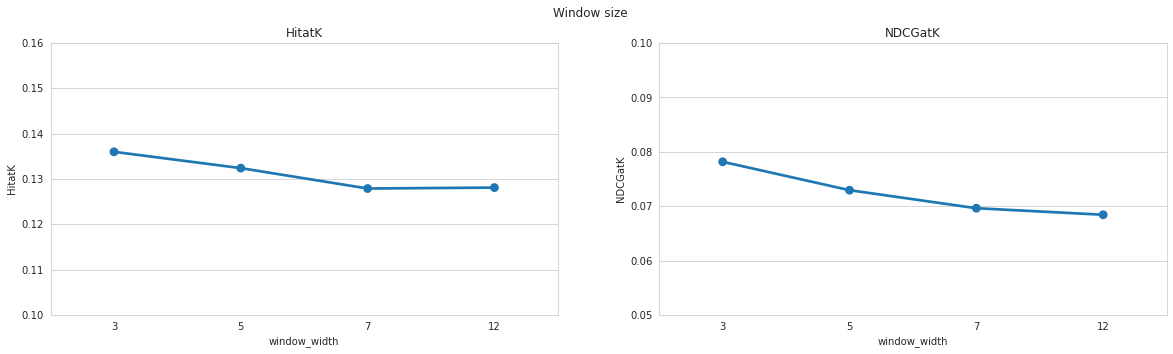

In [27]:
disp_hp(df_window_size, "window_width", "Window size")

> **Observation:** The performance decreases as the windows size increases. The optimal value for window_width is given by the initial configuration, i.e window_width = 3.

**<span style="color:blue;">Negative sample:</span>**
- neg_sample = {5, 10, 15, 20}.
- window_width = 3, sub_samp = 0.00001, samp_coef = 0.5, epochs = 60, vector_dim = 30.

,neg_sample,HitatK,NDCGatK,Loss,Accuracy
0,5,0.1321,0.075290,0.1376,0.9508
1,10,0.1469,0.083547,0.0989,0.9670
2,15,0.1502,0.084300,0.0789,0.9749
3,20,0.1545,0.087570,0.0701,0.9783


Max HitatK: 0.1545, at neg_sample: 20
Max NDCGatK: 0.08757, at neg_sample: 20


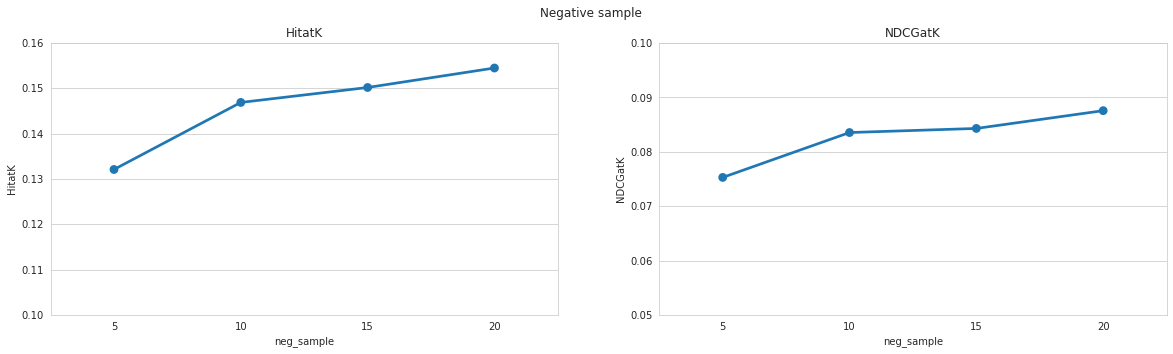

In [28]:
disp_hp(df_neg_sample, "neg_sample", "Negative sample")

> **Observation:** The performance increases with the number of negative sample per positive sample. The initial configuration can be improved by neg_sample, with here the maximum neg_sample = 20.

**<span style="color:blue;">Sub-sample:</span>**

- sub_samp = {0.00001, 0.0001, 0.001, 0.01, 0.1}
- window_width = 3, neg_sample = 5, samp_coef = 0.5, epochs = 60, vector_dim = 30.

,sub_samp,HitatK,NDCGatK,Loss,Accuracy
0,0.00001,0.1340,0.075782,0.1367,0.9508
1,0.00010,0.1348,0.076082,0.1508,0.9440
2,0.00100,0.1419,0.080791,0.1551,0.9422
3,0.01000,0.1346,0.076607,0.1484,0.9449
4,0.10000,0.1408,0.079315,0.1503,0.9442


Max HitatK: 0.1419, at sub_samp: 0.001
Max NDCGatK: 0.080791, at sub_samp: 0.001


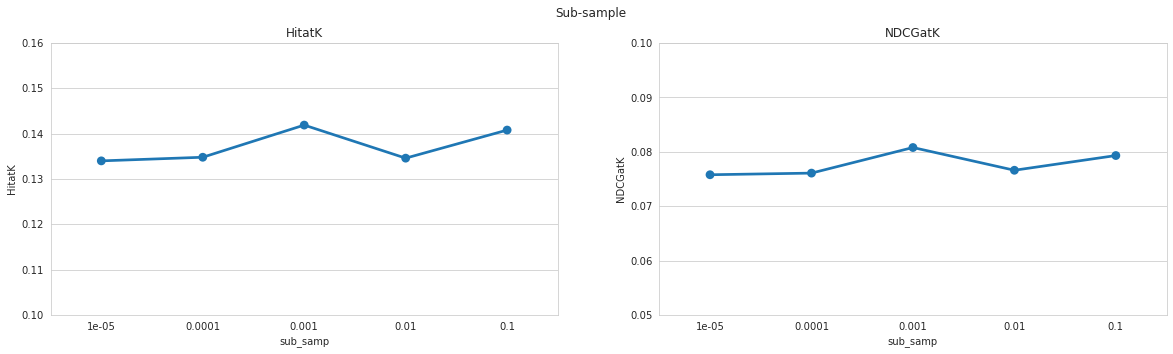

In [29]:
disp_hp(df_sub_samp, "sub_samp", "Sub-sample")

> **Observation:**  The performance increases globally with a higher sub-sample parameter. However, we observe inner variations, as the best performance is given by sub_samp = 0.001, followed closely by sub_samp = 0.1. Nonetheless, the initial configuration can be improved with a higher value of sub_samp.

**<span style="color:blue;">Sample coefficient:</span>**
- samp_coef = {-1.4, -1.2, -1, -0.6, -0.2, 0, 0.2, 0.5, 0.7, 1, 1.4}.
- window_width = 3, neg_sample = 5, sub_samp = 0.00001, epochs = 60, vector_dim = 30.

,samp_coef,HitatK,NDCGatK,Loss,Accuracy
0,-1.4,0.1167,0.067376,0.1026,0.9683
1,-1.2,0.1223,0.070780,0.1140,0.9640
2,-1.0,0.1207,0.068228,0.1098,0.9650
3,-0.6,0.1275,0.073644,0.1212,0.9603
4,-0.2,0.1301,0.073730,0.1202,0.9596
5,0.0,0.1354,0.077140,0.1260,0.9567
6,0.2,0.1359,0.076785,0.1323,0.9544
7,0.5,0.1393,0.079454,0.1406,0.9502
8,0.7,0.1287,0.074486,0.1451,0.9483
9,1.0,0.1260,0.075143,0.1571,0.9432


Max HitatK: 0.1393, at samp_coef: 0.5
Max NDCGatK: 0.079454, at samp_coef: 0.5


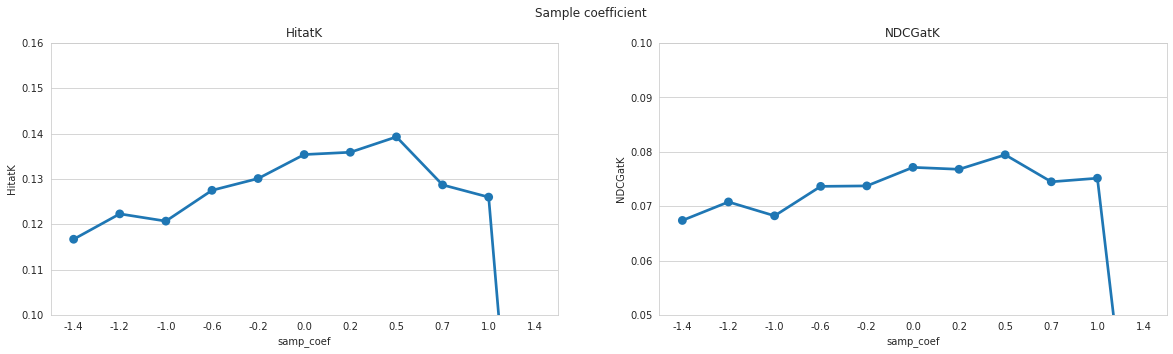

In [30]:
disp_hp(df_samp_coef, "samp_coef", "Sample coefficient")

> **Observation:** The performance reaches a maximum with a sample coefficient of 0.5. The optimal value for samp_coef is given by the initial configuration, i.e samp_coef = 0.5.

**<span style="color:blue;">Epochs:</span>**
- epochs = {10, 50, 60, 90, 110, 150, 200}.
- window_width = 3, neg_sample = 5, sub_samp = 0.00001, samp_coef = 0.5, vector_dim = 30.

,epochs,HitatK,NDCGatK,Loss,Accuracy
0,10,0.0939,0.053081,0.3829,0.8783
1,50,0.1394,0.078860,0.1506,0.9468
2,60,0.1406,0.079641,0.1388,0.9506
3,90,0.1269,0.071914,0.1174,0.9570
4,110,0.1278,0.071392,0.1083,0.9597
5,150,0.1183,0.067261,0.1040,0.9609
6,200,0.1202,0.070131,0.0946,0.9644


Max HitatK: 0.1406, at epochs: 60
Max NDCGatK: 0.079641, at epochs: 60


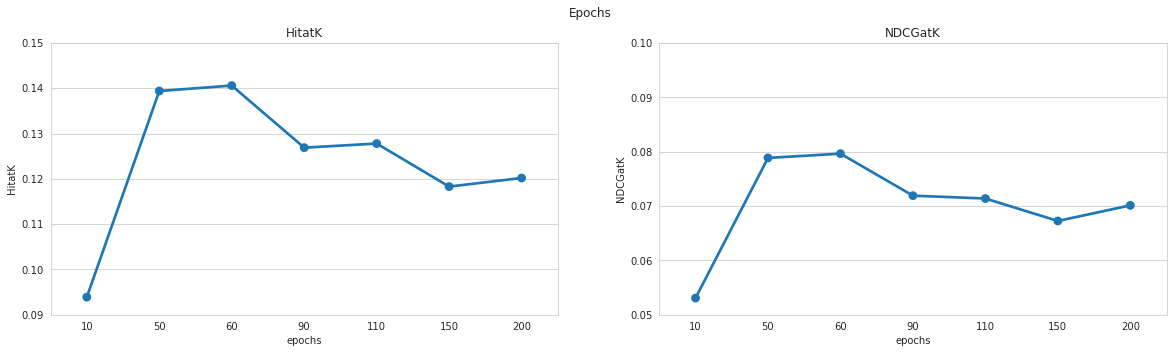

In [31]:
disp_hp(df_epochs, "epochs", "Epochs", y_lim_hitatk=(0.09, 0.15))

> **Observation:** The performance reaches a maximum with 60 epochs. The optimal value for epochs is given by the initial configuration, i.e epochs = 60.

**<span style="color:blue;">Latent space dimension:</span>**
- vector_dim = {30, 50, 100, 150, 200}.
- window_width = 3, neg_sample = 5, sub_samp = 0.00001, samp_coef = 0.5, epochs = 60.

,vector_dim,HitatK,NDCGatK,Loss,Accuracy
0,30,0.1388,0.078715,0.1419,0.9489
1,50,0.1631,0.094257,0.1199,0.9591
2,100,0.1773,0.099686,0.1013,0.9668
3,150,0.1750,0.100568,0.0940,0.9702
4,200,0.1752,0.100458,0.0888,0.9717


Max HitatK: 0.1773, at vector_dim: 100
Max NDCGatK: 0.100568, at vector_dim: 150


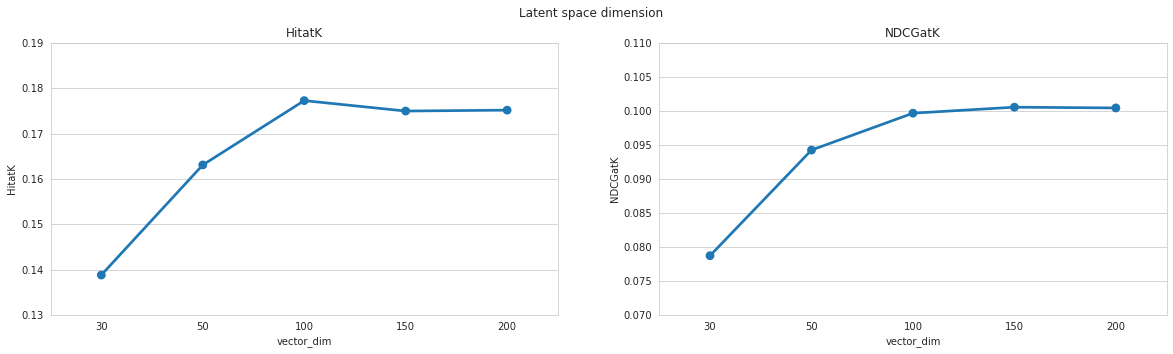

In [32]:
disp_hp(df_vector_dim, "vector_dim", "Latent space dimension", y_lim_hitatk=(0.13, 0.19), y_lim_ndcgatk=(0.07, 0.11))

> **Observation:** The perfomance peaks at vector_dim = 100, before reaching a pleateau and decreasing slightly. The initial value of vector_dim can be improved to 100.

### <span style="color:green;">Step 3: Combine tuned hyperparameters and size of the mini batches</span>

Here, we will build on the results obtained at step 2 to improve the performance, by combining the optimal values found for the hyperparameters.

We have found out that the hyperparameters with a margin of improvement are:
> 1. The number of negative sample per positive sample.
> 2. The sub-sample parameter.
> 3. The latent space dimension.

At first, we run the combination of the best values previously found for vector_dim, neg_sample and sub_samp, while leaving the window size, sample coefficient and epochs as in the initial configuration, i.e.:

> | vector_dim | neg_sample | sub_samp | window_width | samp_coef | epochs | 
> | --- | --- | --- | --- | --- | --- |
> | 100 | 20 | 0.1 | 3 | 0.5 | 60 |

This will give us our optimal configuration for the hyperparameter ranges given by the paper.

Furthermore, although the paper does not discuss the impact of the mini batch size on the performance, this hyperparameter can also affect performance. We thus apply variations of min_batch_size on our configuration obtained so far, using a common range of values: 32, 64, 128, 256.

> - vector_dim = 100, neg_sample = 20, sub_samp = 0.1, window_width = 3, samp_coef = 0.5, epochs = 60.
> - min_batch_size = {32, 50, 64, 128, 256}

Finaly, we will thus find our optimal and final configuration.

In [33]:
# Combined tuning
df_combine = pd.DataFrame({
    "HitatK": [0.1749],
    "NDCGatK": [0.1019380356946984],
    "Loss": [0.0579],
    "Accuracy": [0.9809]
})

# Varying the mini batch size
df_min_batch_size = pd.DataFrame({
    "min_batch_size": [32, 50, 64, 128, 256],
    "HitatK": [0.1699, 0.1749, 0.1812, 0.18, 0.1758],
    "NDCGatK": [0.09702403940587606, 0.1019380356946984, 0.10629096014729121, 0.10605334157833587, 0.1028305128561876],
    "Loss": [0.0635, 0.0579, 0.0566, 0.05, 0.0450],
    "Accuracy": [0.9797, 0.9809, 0.9808, 0.9828, 0.9843]
})

**<span style="color:blue;">Combining the optimal hyperparameters from step 2:</span>**

- vector_dim = 100
- neg_sample = 20
- sub_samp = 0.1.
- window_width = 3, samp_coef = 0.5, epochs = 60

In [34]:
df_combine

,HitatK,NDCGatK,Loss,Accuracy
0,0.1749,0.101938,0.0579,0.9809


> **Observation:** The performance of this configuration is the best obtained within the ranges proposed in the paper. Hence, by tuning the initial configuration with vector_dim = 100, neg_sample = 20 and sub_samp = 0.1, the performance is highly improved:
> - HitatK = 0.1749
> - NDCGatK = 0.101938

**<span style="color:blue;">Varying the size of the mini batches on the optimal configuration:</span>**

- vector_dim = 100, neg_sample = 20, sub_samp = 0.1, window_width = 3, samp_coef = 0.5, epochs = 60.
- min_batch_size = {32, 50, 64, 128, 256}

,min_batch_size,HitatK,NDCGatK,Loss,Accuracy
0,32,0.1699,0.097024,0.0635,0.9797
1,50,0.1749,0.101938,0.0579,0.9809
2,64,0.1812,0.106291,0.0566,0.9808
3,128,0.1800,0.106053,0.0500,0.9828
4,256,0.1758,0.102831,0.0450,0.9843


Max HitatK: 0.1812, at min_batch_size: 64
Max NDCGatK: 0.106291, at min_batch_size: 64


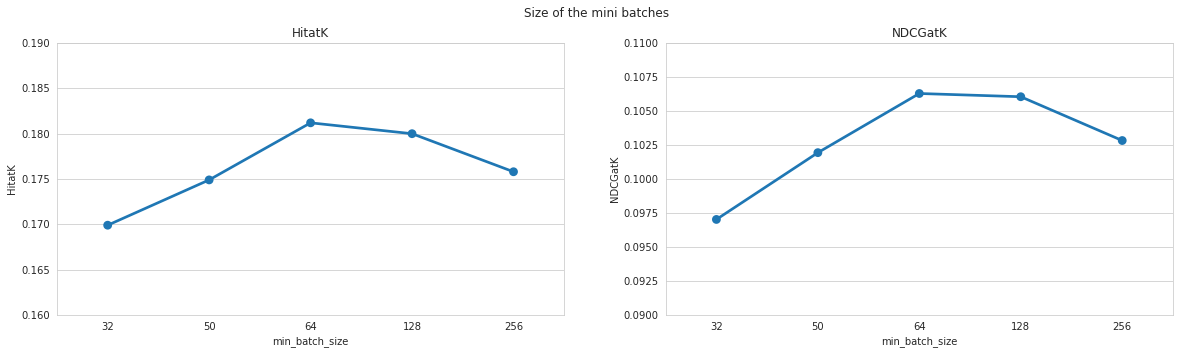

In [35]:
disp_hp(df_min_batch_size, "min_batch_size", "Size of the mini batches", y_lim_hitatk=(0.16, 0.19), y_lim_ndcgatk=(0.09, 0.11))

> **Observation:** The optimal and final configuration is reached at min_batch_size = 64:
> - HitatK = 0.1812
> - NDCGatK = 0.106291

### <span style="color:green;">Conclusion</span>

**Optimal configuration:** 
> - min_batch_size = 64
> - vector_dim = 100
> - neg_sample = 20
> - sub_samp = 0.1
> - window_width = 3
> - samp_coef = 0.5
> - epochs = 60

**Performance:**
> - HitatK = 0.1812
> - NDCGatK = 0.106291

**Nota bene:**
> While changing the latent space dimension and the size of the mini batches significatively improved our results, the gain in performance came at the cost of computation time. In fact, the amount of operations performed during learning vastly increases with bigger values for these two hyperparameters, which led to a runtime more than twice as long at the optimal configuration than at the initial configuration. Thus, another approach to this exercise could be to find the optimal tradeoff between performance and learning time.

## Bonus, a little music

The TrackArtists file contains meta.data on the tracks and the artists for a subset of the 300,000 tracks in the dataset. We can use it to search for the number of a song from its title:

In [36]:
# import pandas as pd
tr_meta=pd.read_csv("./TracksArtists.csv")
joindf = pd.DataFrame({"track_id":tracks_list_ordered[:Vt],"index":range(Vt)})
meta = tr_meta.merge(joindf, left_on="track_id",right_on="track_id")
meta.set_index("index",inplace=True)
meta[["title","name","preview","track_id"]]

,title,name,preview,track_id
index,,,,
14086,Alone,Petit Biscuit,http://cdn-preview-8.deezer.com/stream/c-89176...,track_100001884
1519,Memories,Petit Biscuit,http://cdn-preview-8.deezer.com/stream/c-883c9...,track_102400504
1127,Sunset Lover,Petit Biscuit,NaN,track_102400506
22812,Night Trouble,Petit Biscuit,http://cdn-preview-b.deezer.com/stream/c-b1808...,track_102400604
12644,Palms,Petit Biscuit,http://cdn-preview-3.deezer.com/stream/c-3e57c...,track_102420192
...,...,...,...,...
22784,Donde Estés Llegaré,Alexis y Fido,http://cdn-preview-5.deezer.com/stream/c-542bf...,track_9975788
13071,Camuflaje,Alexis y Fido,http://cdn-preview-b.deezer.com/stream/c-b249e...,track_9975792
22782,Mala Conducta,Alexis y Fido,http://cdn-preview-a.deezer.com/stream/c-af834...,track_9975794


In [37]:
def find_track(title):
    return meta.loc[meta["title"]==title,:].index[0]

tr=find_track("ocean eyes")
tr

17113

## Radio

The deeezer api allows you to retrieve information about the pieces of the dataset from their deezer id. Among this information when it is available a url to listen to a free sample is provided.

In [38]:
import urllib.request, json 
def gettrackinfo(number):
    track_url =  "https://api.deezer.com/track/{}".format(tracks_list_ordered[number].split("_")[1])
    with urllib.request.urlopen(track_url) as url:
        data = json.loads(url.read().decode())
    return data
track_apidata = gettrackinfo(find_track("ocean eyes"))
track_apidata

{'id': 136337268,
 'readable': True,
 'title': 'ocean eyes',
 'title_short': 'ocean eyes',
 'title_version': '',
 'isrc': 'US23A1500056',
 'link': 'https://www.deezer.com/track/136337268',
 'share': 'https://www.deezer.com/track/136337268?utm_source=deezer&utm_content=track-136337268&utm_term=0_1611938822&utm_medium=web',
 'duration': 200,
 'track_position': 1,
 'disk_number': 1,
 'rank': 897029,
 'release_date': '2016-11-18',
 'explicit_lyrics': False,
 'explicit_content_lyrics': 0,
 'explicit_content_cover': 0,
 'preview': 'https://cdns-preview-7.dzcdn.net/stream/c-7bd3f9311d5b85d8ca950fd504f28521-6.mp3',
 'bpm': 145.07,
 'gain': -8.4,
 'available_countries': ['AE',
  'AF',
  'AG',
  'AI',
  'AL',
  'AM',
  'AO',
  'AQ',
  'AR',
  'AS',
  'AT',
  'AU',
  'AZ',
  'BA',
  'BB',
  'BD',
  'BE',
  'BF',
  'BG',
  'BH',
  'BI',
  'BJ',
  'BN',
  'BO',
  'BQ',
  'BR',
  'BT',
  'BV',
  'BW',
  'BY',
  'CA',
  'CC',
  'CD',
  'CF',
  'CG',
  'CH',
  'CI',
  'CK',
  'CL',
  'CM',
  'CO',
  '

So we can use it to listen a preview:

In [39]:
from IPython.display import display, Audio, clear_output
display(Audio(track_apidata["preview"],autoplay=True))

<span style="color:red">Create a radio function that takes as input a track number in the dataset and launches a series of nb_track tracks by randomly pulling in the neighborhood of the current track the next track to listen to. The size of the neighborhood will be configurable and you will delete from the proposals the songs already listened to. You will handle exceptions if the track does not have an available extract. You can delete the current song with the clear_display function.</span>

In [40]:
import time
def start_radio(seed,nb_candidates,duration,nbsteps=20):
    print(meta.loc[seed,"title"])
    display(Audio(meta.loc[seed,"preview"],autoplay=True))
    time.sleep(duration)
    clear_output(True)
    already_played = [seed]
    for i in range(nbsteps):
        print(f"#{i+1}")
        track = random.choice([t for t in 
                               list(predict_batch([already_played[-1]],nb_candidates,vectors_tracks,kdt)[0])
                               if not t in already_played])
        already_played.append(track)
        try:
            print(meta.loc[track,"title"])
            display(Audio(meta.loc[track,"preview"],autoplay=True))
            time.sleep(duration)
        except:
            print("track not found")
            time.sleep(1)
            pass
        clear_output(True)

In [43]:
start_radio(find_track("Memories"),10,10,20)

#20
Daydream
